 # Finding the best place for a new well through machine learning

We work for 'OilyGiant mining company'. Our task is to find the best place for a new well.

## Contents <a id='back'></a>

* [Intro](#intro)
* [Stage 1. Data loading](#1)
    * [1.1 Data exploration](#1.1)
    * [1.2 Graphical data exploration](#1.2)
* [Stage 2. Data preprocessing](#2)
* [Stage 3. Model training](#3)
* [Stage 4. Margin calculation](#4)
* [Stage 5. Risks and profit calculation](#5)
* [Conclusion](#conclusion)

## Introduction <a id='intro'></a>

We have data of oil wells in three regions. The parameters of each oil well in the regions are already known. The goal is to create a model that helps to choose the region with the highest profit margin and analyzing potential benefits and risks using the bootstrapping technique.

## Stage 1. Data loading <a id='1'></a>

In [1]:
# General libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
# Load the data files into DataFrame
try:
    df_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    df_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    df_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')
except:
    df_0 = pd.read_csv('/datasets/geo_data_0.csv')
    df_1 = pd.read_csv('/datasets/geo_data_1.csv')
    df_2 = pd.read_csv('/datasets/geo_data_2.csv')

### 1.1 Data exploration <a id='1.1'></a>

In [3]:
# printing the general/summary information and first rows of df_0
df_0.info()
df_0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
# printing the general/summary information and first rows of df_1
df_1.info()
df_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [5]:
# printing the general/summary information and first rows of df_2
df_2.info()
df_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


So, we have data about geological exploration of three regions. Columns are the same for all three datasets:
- `id` — oil well unique identifier
- `f0, f1, f2` — three characteristics (their specific meaning is not important, but the values themselves are significant)
- `product` — reserves volume in the oil well (thousands of barrels).

In [6]:
# checking for any duplicated rows
df_all = [df_0, df_1, df_2]
i=0
for df in df_all:
    print('Duplicated rows in region {}: {}'.format(i, df.duplicated().sum()))
    i+=1

Duplicated rows in region 0: 0
Duplicated rows in region 1: 0
Duplicated rows in region 2: 0


So, df_0, df_1, df_2 are 100000 rows and 5 columns dataframes with no null values and no duplicated rows. Types of columns is coherent with their info.

Let's see the number of unique values for every column of each region:

In [7]:
unique = pd.DataFrame(columns=['region', 'id', 'F0', 'F1', 'F2', 'product'])
i=0

for df in df_all:
    new_row = {'region': i, 'id': df['id'].nunique(), 'F0': df['f0'].nunique(), 'F1': df['f1'].nunique(), 'F2': df['f2'].nunique(), 'product': df['product'].nunique()}
    unique = pd.concat([unique,pd.DataFrame([new_row])], ignore_index=True)
    i+=1
unique

,region,id,F0,F1,F2,product
0,0,99990,100000,100000,100000,100000
1,1,99996,100000,100000,100000,12
2,2,99996,100000,100000,100000,100000


So, there is a clear outsider. The region 1 has only 12 unique product. This could affect the quality of the trained model. We'll see it later !

### 1.2 Graphical data exploration <a id='1.2'></a>

Lets see what feature has more "weight" on the target, in our case the variable "Product". So we use a correlation matrix to do it:

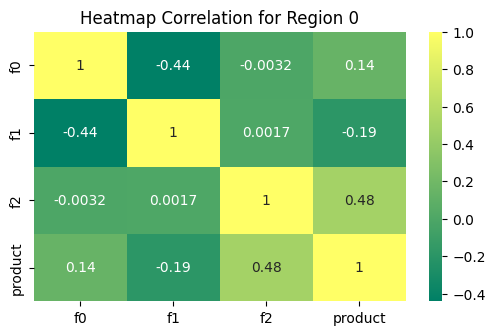

In [8]:
# correlation matrix for region 0
plt.figure(figsize = (6,3.5))
df0_corr = df_0.drop('id', axis='columns')
sns.heatmap(df0_corr.corr(), annot = True, cmap = 'summer')
plt.title('Heatmap Correlation for Region 0')
plt.show()

We see that there is a strong correlation between f2 and product

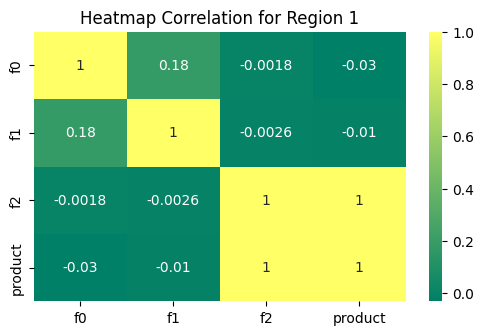

In [9]:
# correlation matrix for region 1
plt.figure(figsize = (6,3.5))
df1_corr = df_1.drop('id', axis='columns')
sns.heatmap(df1_corr.corr(), annot = True, cmap = 'summer')
plt.title('Heatmap Correlation for Region 1')
plt.show()

For region 1, the correlation between f2 and product is definitive and they are directly proportional.

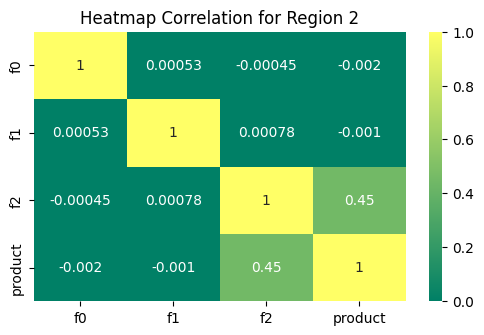

In [10]:
# correlation matrix for region 2
plt.figure(figsize = (6,3.5))
df2_corr = df_2.drop('id', axis='columns')
sns.heatmap(df2_corr.corr(), annot = True, cmap = 'summer')
plt.title('Heatmap Correlation for Region 2')
plt.show()

Region 2 is similar, by correlation, to region 0

Let's see now the distribution of 'product' for each region:

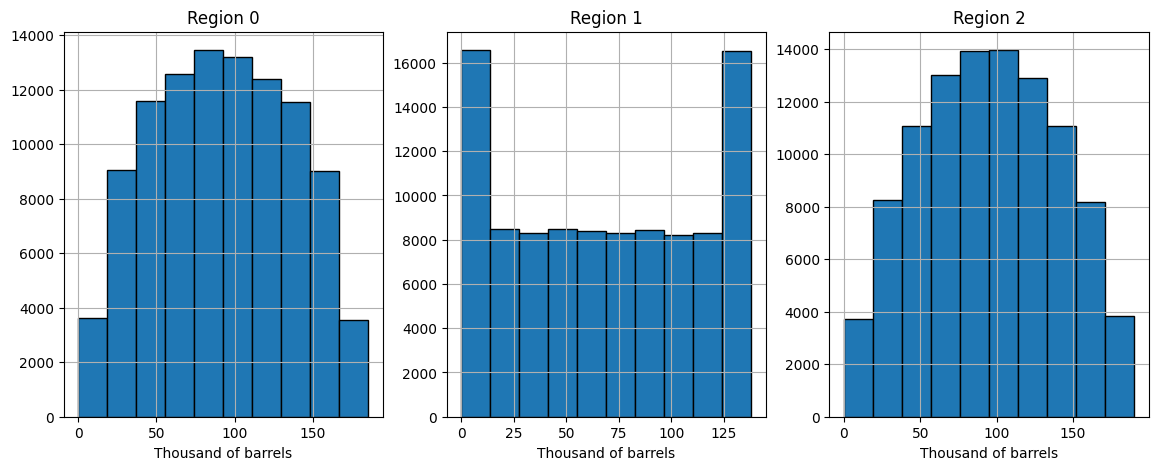

In [11]:
fig, ax = plt.subplots(figsize=(14,5), nrows=1, ncols=3, edgecolor = 'black')
i=0

for df in df_all:
    ax[i].hist(df['product'], edgecolor = 'black')
    ax[i].set_title('Region {}'.format(i))
    ax[i].set_xlabel('Thousand of barrels')
    ax[i].grid(True)
    i+=1

plt.show()

Region 0 and region 2 have normal distibution. Region 1 doesn't.

## Stage 2. Data preprocessing <a id='2'></a>

We saw before that there are some duplicated values in 'id' column of each region. Having 99990 unique values in 'id' means that there are 10 duplicated values. We have to drop them:

In [12]:
# dropping duplicated values in id column in df_0, df_1 and df_2
for df in df_all:
    df = df.drop_duplicates(subset=['id'], keep='first')

The attribute 'first' means that we drop duplicates except for the first occurrence.

## Stage 3. Model training <a id='3'></a>

As stated before, we want to build a model that predicts the reserve volume of new wells. Since our target is numerical, we have a regression task and more precisely a linear regression. 

The process in this case will be iterative through the three regions. What we do is:
- initialize the lists for features_train, features_valid etc.
- define a random state
- initialize a dataframe with specific columns

At every iteration, we append the new features_train, features_valid etc. to the list, we train the model, use it to make predictions and append them to a list. Finally we print our initialized table filled row by row for each region.

In [13]:
features_train = []
features_valid = []
target_train = []
target_valid = []
predictions = []
state = np.random.RandomState(12345)
table_1 = pd.DataFrame(columns=['region', 'pred_mean', 'targ_mean', 'RMSE'])
i=0

for df in df_all:
    X = df.drop(['id', 'product'], axis=1)
    Y = df['product']
    X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size = 0.25, random_state = state)

    features_train.append(X_train)
    features_valid.append(X_valid)
    target_train.append(Y_train)
    target_valid.append(Y_valid)

    model = LinearRegression()
    model.fit(X_train, Y_train)
    pred = model.predict(X_valid)
    predictions.append(pred)

    new_row = {'region': i, 'pred_mean': round(pred.mean(),2), 'targ_mean': round(Y_train.mean(),2), 'RMSE': round(mean_squared_error(Y_valid, pred) ** 0.5,2)}
    table_1 = pd.concat([table_1,pd.DataFrame([new_row])], ignore_index=True)
    i+=1

table_1

,region,pred_mean,targ_mean,RMSE
0,0,92.59,92.64,37.58
1,1,68.77,68.84,0.89
2,2,95.09,95.08,39.96


First thing that jumps into the eyes is that, for all regions, mean predictions are close to mean target. About RMSE, it must be said that the lower it is the better is the model fit. In our case, RMSE is way lower for region 1. This is because region 1 has only 12 unique product.

## Stage 4. Margin calculation <a id='4'></a>

Let's start this calculation assigning the key values:

In [14]:
n_of_wells = 200 # 200 best wells chosen for the study
budget = 100000000   # 100 millions $ of budget for each region
barrel_profit = 4.5 # $
product_profit = 4500 # profit for unity of product

Now we can easily get the average cost to work an oil well

In [15]:
cost_well = budget/n_of_wells
print(int(cost_well), '$ investment for every well')

500000 $ investment for every well


So, at this point we can get the rough number of barrels that we have to extract to get a margin from a single well

In [16]:
num_barrels = cost_well/barrel_profit
print('It takes', round(num_barrels, 2), 'barrels of oil to make a margin from a single well')

It takes 111111.11 barrels of oil to make a margin from a single well


Since it can't be possible to produce exactly 111111.11 barrels (barrels can only be sold full filled), we can state that 111112 is the number of barrels to extract to get a margin from a single well

Let's compare the value obtained with the average volume of reserves for each region:

In [17]:
i=0
for df in df_all:    
    print('The average volume of the oil wells in region {} is {:.1f} thousand barrels '.format(i, df['product'].mean()))
    i+=1

The average volume of the oil wells in region 0 is 92.5 thousand barrels 
The average volume of the oil wells in region 1 is 68.8 thousand barrels 
The average volume of the oil wells in region 2 is 95.0 thousand barrels 


So, the average volume of the wells in the regions is far lower than the minumum capacity needed to provide a benefit for the oil company. This means that the large majority of oil wells are not suitable for drilling.

Let's now write a function to calculate the earnings of the 200 biggest wells of each region:

In [18]:
def profit(target, predictions, count):
    pred_sorted = pd.Series(predictions).reset_index(drop = True).sort_values(ascending=False)
    target_selected = pd.Series(target).iloc[pred_sorted.index].head(count)
    
    volume = target_selected.sum()
    income = volume*product_profit
    tot_cost = cost_well*count
    margin = income-tot_cost
    return margin

In [19]:
for i in range(len(df_all)):
    print('Margin for Region {}: {:.2f} million USD'.format(i, profit(target_valid[i], predictions[i], n_of_wells)/10**6))

Margin for Region 0: 33.21 million USD
Margin for Region 1: 24.15 million USD
Margin for Region 2: 25.40 million USD


So, region 0 should be the most profitable.

## Stage 5. Risks and profit calculation <a id='5'></a>

To assess the risks and profits for each region, we use the bootstrapping technique with 1000 samples. In this way we'll find the distribution of potential margin.

We aim to evaluate the average profit, 95% confidence interval and risk of losses for each region.

In [20]:
def bootstrap(target, prediction):
    values = []
    target = target.reset_index(drop=True)

    for i in range(1000):
        target_sample = target.sample(n = 500, replace=True, random_state=state)
        pred_sample = prediction[target_sample.index]
        values.append(profit(target_sample, pred_sample, n_of_wells))
    values = pd.Series(values)

    avg = np.round(values.mean()/10**6, 3)
    lower = np.round(values.quantile(0.025)/10**6, 3)
    upper = np.round(values.quantile(0.975)/10**6, 3)
    confidence_interval = (lower, upper)
    risk = np.round(((values < 0).sum() / len(values)) * 100, 2)

    return avg, lower, upper, confidence_interval, risk

In [21]:
table_2 = pd.DataFrame(columns=['region', 'Average profit', '2.5% Quant', '97.5% Quant', '95% Confidence Interval', 'Risk %'])
i=0

for region in range(len(df_all)):
    avg, lower, upper, confidence_interval, risk = bootstrap(target_valid[region], predictions[region])

    new_row = {'region': i, 'Average profit': avg, '2.5% Quant': lower, '97.5% Quant': upper, '95% Confidence Interval': confidence_interval, 'Risk %': risk}
    table_2 = pd.concat([table_2,pd.DataFrame([new_row])], ignore_index=True)
    i+=1

table_2

,region,Average profit,2.5% Quant,97.5% Quant,95% Confidence Interval,Risk %
0,0,3.943,-0.695,9.155,"(-0.695, 9.155)",6.1
1,1,4.547,0.611,8.559,"(0.611, 8.559)",0.7
2,2,3.537,-1.627,8.478,"(-1.627, 8.478)",7.6


Values are expressed in million dollars. From what we see, the region with bigger profit and lowest risk is region 1. Is curious the fact that for region 0 and 2 there is a negative lowest quantile.

## Conclusion <a id='conclusion'></a>

We started our project with the aim of creating a model that helps to choose the region with the highest profit. The oil company gave us 3 csv files (each one for a different region) with 100000 observations each.

As usual the first thing we did was to explore data, graphically as well. First unusual thing we found was that in the 'product' column of df_1 there were only 12 unique values and the correlation between 'f2' and 'product' is maximum. This property is reflected during the model training, when the RMSE of df_1 is way lower than the others.

We ran a little preprocessing, dropping some duplicated values for 'id' column.

After that, we used a for loop to iterate through all 3 dataframes, splitting the three dataframes into train set and validation set (75:25). We trained the model and used this to make predictions.

The earning calculation followed, declaring all the needed variables and making simple calculations until defining a function that computes the marging of every region.

Finally we used the bootstrapping technique to verify the profit distribution for every region, meaning the lower and upper quantile, the confidence interval and the risk associated.

We draw the conclusion that region 1 is the most profitable and less risky.